In [1]:
!pip install fbm yfinance alpha_vantage

In [2]:
!pip install quantlib-python stochastic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-

In [5]:
!pip install kaleido
!pip install arch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 13.6 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Financial data
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

# Scientific computing
from scipy import stats
from scipy.optimize import minimize, minimize_scalar
from scipy.special import gamma
from sklearn.metrics import mean_squared_error

# Fractional Brownian Motion
from fbm import FBM
import datetime

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [17]:
class DataManager:
    """Handles financial data acquisition and preprocessing"""

    def __init__(self):
        self.stock_data = None
        self.options_data = None

    def get_stock_data(self, ticker, period="2y"):
        """Download stock price data from Yahoo Finance"""
        try:
            stock = yf.Ticker(ticker)
            self.stock_data = stock.history(period=period)

            # Calculate returns
            self.stock_data['Returns'] = np.log(self.stock_data['Close'] / self.stock_data['Close'].shift(1))
            self.stock_data['Returns'] = self.stock_data['Returns'].dropna()

            print(f"Downloaded {len(self.stock_data)} days of data for {ticker}")
            print(f"Date range: {self.stock_data.index[0].date()} to {self.stock_data.index[-1].date()}")

            return self.stock_data

        except Exception as e:
            print(f"Error downloading data: {e}")
            return None

    def get_options_data(self, ticker):
        """Get options chain data"""
        try:
            stock = yf.Ticker(ticker)
            exp_dates = stock.options

            if len(exp_dates) > 0:
                # Get the first available expiration date
                options_chain = stock.option_chain(exp_dates[0])
                self.options_data = {
                    'calls': options_chain.calls,
                    'puts': options_chain.puts,
                    'expiration': exp_dates[0]
                }
                print(f"Downloaded options data for expiration: {exp_dates[0]}")
                return self.options_data
            else:
                print("No options data available")
                return None

        except Exception as e:
            print(f"Error downloading options data: {e}")
            return None

    def get_summary_stats(self):
        """Calculate summary statistics"""
        if self.stock_data is None:
            return None

        returns = self.stock_data['Returns'].dropna()

        stats_dict = {
            'Mean Return (Annual)': returns.mean() * 252,
            'Volatility (Annual)': returns.std() * np.sqrt(252),
            'Skewness': stats.skew(returns),
            'Kurtosis': stats.kurtosis(returns),
            'Jarque-Bera p-value': stats.jarque_bera(returns)[1],
            'Min Return': returns.min(),
            'Max Return': returns.max(),
            'VaR (95%)': returns.quantile(0.05)
        }

        return pd.Series(stats_dict)

# Initialize data manager and download data
data_manager = DataManager()

# Download Apple stock data (you can change the ticker)
TICKER = "AAPL"
stock_data = data_manager.get_stock_data(TICKER, period="2y")
options_data = data_manager.get_options_data(TICKER)

# Display summary statistics
print("\nSUMMARY STATISTICS")
print("=" * 50)
summary_stats = data_manager.get_summary_stats()
for stat, value in summary_stats.items():
    if 'p-value' in stat:
        print(f"{stat:<25}: {value:.6f}")
    else:
        print(f"{stat:<25}: {value:.4f}")


Downloaded 502 days of data for AAPL
Date range: 2023-09-25 to 2025-09-24
Downloaded options data for expiration: 2025-09-26

SUMMARY STATISTICS
Mean Return (Annual)     : 0.1845
Volatility (Annual)      : 0.2771
Skewness                 : 0.6094
Kurtosis                 : 11.5711
Jarque-Bera p-value      : 0.000000
Min Return               : -0.0970
Max Return               : 0.1426
VaR (95%)                : -0.0269


In [19]:
class FractionalBrownianMotion:
    """Advanced fBM implementation with multiple simulation methods"""

    def __init__(self, hurst=0.7, length=1.0, n_steps=252):
        self.hurst = hurst
        self.length = length
        self.n_steps = n_steps
        self.dt = length / n_steps

    def generate_fbm_path(self, method='daviesharte'):
        """Generate single fBM path"""
        fbm_gen = FBM(n=self.n_steps, hurst=self.hurst, length=self.length, method=method)
        return fbm_gen.fbm()

    def generate_fgn_increments(self, method='daviesharte'):
        """Generate fractional Gaussian noise increments"""
        fbm_gen = FBM(n=self.n_steps, hurst=self.hurst, length=self.length, method=method)
        return fbm_gen.fgn()

    def generate_asset_paths(self, S0, mu, sigma, n_paths=1000, method='daviesharte'):
        """Generate asset price paths using fBM"""
        paths = np.zeros((n_paths, self.n_steps + 1))
        paths[:, 0] = S0

        for i in range(n_paths):
            # Generate fGN increments
            fgn_increments = self.generate_fgn_increments(method)

            # Convert to log-price increments
            # Using the proper scaling for fBM in finance
            log_increments = (mu - 0.5 * sigma**2) * self.dt + \
                           sigma * (self.dt**self.hurst) * fgn_increments

            # Generate price path
            log_prices = np.cumsum(log_increments)
            paths[i, 1:] = S0 * np.exp(log_prices)

        return paths

    def compare_with_gbm(self, S0, mu, sigma, n_paths=1000):
        """Compare fBM paths with standard GBM"""
        # Generate fBM paths
        fbm_paths = self.generate_asset_paths(S0, mu, sigma, n_paths)

        # Generate GBM paths for comparison
        gbm_paths = np.zeros((n_paths, self.n_steps + 1))
        gbm_paths[:, 0] = S0

        dt = self.length / self.n_steps
        for i in range(n_paths):
            random_increments = np.random.normal(0, 1, self.n_steps)
            log_increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * random_increments
            log_prices = np.cumsum(log_increments)
            gbm_paths[i, 1:] = S0 * np.exp(log_prices)

        return fbm_paths, gbm_paths

class HurstEstimator:
    """Multiple methods for estimating Hurst parameter"""

    @staticmethod
    def rs_method(returns, max_lag=None):
        """Rescaled Range (R/S) method"""
        n = len(returns)
        if max_lag is None:
            max_lag = int(n/4)

        lags = np.logspace(np.log10(10), np.log10(max_lag), 20).astype(int)
        rs_values = []

        for lag in lags:
            # Split series into non-overlapping segments
            n_segments = n // lag
            if n_segments < 2:
                continue

            rs_segment = []
            for i in range(n_segments):
                segment = returns[i*lag:(i+1)*lag]
                if len(segment) < lag:
                    continue

                # Calculate cumulative deviations
                mean_segment = np.mean(segment)
                cumulative_deviations = np.cumsum(segment - mean_segment)

                # Calculate range and standard deviation
                R = np.max(cumulative_deviations) - np.min(cumulative_deviations)
                S = np.std(segment)

                if S > 0:
                    rs_segment.append(R/S)

            if len(rs_segment) > 0:
                rs_values.append(np.mean(rs_segment))

        # Linear regression in log-log space
        if len(rs_values) >= 3:
            valid_lags = lags[:len(rs_values)]
            log_lags = np.log(valid_lags)
            log_rs = np.log(rs_values)

            # Remove any infinite values
            finite_mask = np.isfinite(log_lags) & np.isfinite(log_rs)
            if np.sum(finite_mask) >= 3:
                slope, intercept = np.polyfit(log_lags[finite_mask], log_rs[finite_mask], 1)
                return max(0.01, min(0.99, slope))

        return 0.5  # Default to standard Brownian motion

    @staticmethod
    def variance_method(returns, max_lag=100):
        """Variance method for Hurst estimation"""
        n = len(returns)
        if n < max_lag:
            max_lag = n // 2

        lags = np.arange(1, min(max_lag, n//2))
        variances = []

        for lag in lags:
            # Calculate variance of aggregated series
            aggregated = []
            for i in range(0, n-lag+1, lag):
                segment = returns[i:i+lag]
                if len(segment) == lag:
                    aggregated.append(np.sum(segment))

            if len(aggregated) > 1:
                variances.append(np.var(aggregated))

        if len(variances) >= 3:
            valid_lags = lags[:len(variances)]
            log_lags = np.log(valid_lags)
            log_vars = np.log(variances)

            finite_mask = np.isfinite(log_lags) & np.isfinite(log_vars)
            if np.sum(finite_mask) >= 3:
                slope, _ = np.polyfit(log_lags[finite_mask], log_vars[finite_mask], 1)
                hurst = max(0.01, min(0.99, slope / 2))
                return hurst

        return 0.5

# Initialize fBM generator and estimate Hurst parameter
print("ESTIMATING HURST PARAMETER FROM MARKET DATA")
print("=" * 55)

returns = stock_data['Returns'].dropna().values
hurst_estimator = HurstEstimator()

# Estimate Hurst parameter using multiple methods
hurst_rs = hurst_estimator.rs_method(returns)
hurst_var = hurst_estimator.variance_method(returns)
hurst_avg = (hurst_rs + hurst_var) / 2

print(f"Hurst Parameter (R/S method):     {hurst_rs:.4f}")
print(f"Hurst Parameter (Variance method): {hurst_var:.4f}")
print(f"Average Hurst Parameter:          {hurst_avg:.4f}")

# Interpretation
if hurst_avg > 0.5:
    print(f"Interpretation: H = {hurst_avg:.3f} > 0.5 indicates PERSISTENT (trending) behavior")
elif hurst_avg < 0.5:
    print(f"Interpretation: H = {hurst_avg:.3f} < 0.5 indicates ANTI-PERSISTENT (mean-reverting) behavior")
else:
    print(f"Interpretation: H = {hurst_avg:.3f} ≈ 0.5 indicates RANDOM WALK (standard Brownian motion)")

# Initialize fBM generator with estimated parameters
current_price = stock_data['Close'].iloc[-1]
annual_return = summary_stats['Mean Return (Annual)']
annual_vol = summary_stats['Volatility (Annual)']

fbm_generator = FractionalBrownianMotion(hurst=hurst_avg, length=1.0, n_steps=252)

print(f"\nCURRENT MARKET PARAMETERS")
print("=" * 35)
print(f"Current Price:      ${current_price:.2f}")
print(f"Annual Return:      {annual_return:.2%}")
print(f"Annual Volatility:  {annual_vol:.2%}")


ESTIMATING HURST PARAMETER FROM MARKET DATA
Hurst Parameter (R/S method):     0.5724
Hurst Parameter (Variance method): 0.3752
Average Hurst Parameter:          0.4738
Interpretation: H = 0.474 < 0.5 indicates ANTI-PERSISTENT (mean-reverting) behavior

CURRENT MARKET PARAMETERS
Current Price:      $251.65
Annual Return:      18.45%
Annual Volatility:  27.71%


In [20]:
class FractionalOptionsCalculator:
    """Monte Carlo options pricing with fractional Brownian motion"""

    def __init__(self, fbm_generator, risk_free_rate=0.05):
        self.fbm_generator = fbm_generator
        self.risk_free_rate = risk_free_rate

    def black_scholes_price(self, S, K, T, r, sigma, option_type='call'):
        """Standard Black-Scholes pricing for comparison"""
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)

        if option_type.lower() == 'call':
            price = S*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
        else:
            price = K*np.exp(-r*T)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)

        return price

    def calculate_greeks_numerical(self, S, K, T, r, sigma, n_paths=100000, epsilon=0.01):
        """Calculate Greeks using numerical differentiation"""
        base_price = self.monte_carlo_option_price(S, K, T, r, sigma, 'call', n_paths)['price']

        # Delta: ∂V/∂S
        price_up = self.monte_carlo_option_price(S*(1+epsilon), K, T, r, sigma, 'call', n_paths)['price']
        price_down = self.monte_carlo_option_price(S*(1-epsilon), K, T, r, sigma, 'call', n_paths)['price']
        delta = (price_up - price_down) / (2 * S * epsilon)

        # Gamma: ∂²V/∂S²
        gamma = (price_up - 2*base_price + price_down) / ((S * epsilon)**2)

        # Vega: ∂V/∂σ
        vega_up = self.monte_carlo_option_price(S, K, T, r, sigma*(1+epsilon), 'call', n_paths)['price']
        vega_down = self.monte_carlo_option_price(S, K, T, r, sigma*(1-epsilon), 'call', n_paths)['price']
        vega = (vega_up - vega_down) / (2 * sigma * epsilon)

        # Theta: ∂V/∂T (approximated with small time step)
        if T > epsilon:
            theta_down = self.monte_carlo_option_price(S, K, T-epsilon, r, sigma, 'call', n_paths)['price']
            theta = (base_price - theta_down) / epsilon
        else:
            theta = 0

        return {
            'delta': delta,
            'gamma': gamma,
            'vega': vega / 100,  # Vega per 1% change in volatility
            'theta': theta
        }

    def monte_carlo_option_price(self, S0, K, T, r, sigma, option_type='call', n_paths=1000000):
        """Monte Carlo option pricing using fBM"""

        # Update fBM parameters
        self.fbm_generator.length = T
        self.fbm_generator.n_steps = max(int(T * 252), 50)  # Daily steps

        # Generate asset paths
        paths = self.fbm_generator.generate_asset_paths(S0, r, sigma, n_paths)

        # Extract terminal prices
        terminal_prices = paths[:, -1]

        # Calculate payoffs
        if option_type.lower() == 'call':
            payoffs = np.maximum(terminal_prices - K, 0)
        else:
            payoffs = np.maximum(K - terminal_prices, 0)

        # Discount to present value
        option_price = np.exp(-r * T) * np.mean(payoffs)

        # Calculate statistics
        std_error = np.std(payoffs) / np.sqrt(n_paths) * np.exp(-r * T)
        confidence_interval = 1.96 * std_error

        return {
            'price': option_price,
            'std_error': std_error,
            'confidence_interval': confidence_interval,
            'payoffs_mean': np.mean(payoffs),
            'payoffs_std': np.std(payoffs),
            'paths_used': n_paths,
            'terminal_prices': terminal_prices[:1000]  # Sample for analysis
        }

    def price_options_grid(self, S0, strikes, expiries, r, sigma, option_type='call', n_paths=500000):
        """Price options across multiple strikes and expiries"""
        results = []

        total_combinations = len(strikes) * len(expiries)
        current_combination = 0

        for T in expiries:
            for K in strikes:
                current_combination += 1
                print(f"Pricing option {current_combination}/{total_combinations}: K={K}, T={T:.2f}y", end='\r')

                # fBM pricing
                fbm_result = self.monte_carlo_option_price(S0, K, T, r, sigma, option_type, n_paths)

                # Black-Scholes comparison
                bs_price = self.black_scholes_price(S0, K, T, r, sigma, option_type)

                results.append({
                    'Strike': K,
                    'Expiry': T,
                    'fBM_Price': fbm_result['price'],
                    'BS_Price': bs_price,
                    'Price_Difference': fbm_result['price'] - bs_price,
                    'Relative_Difference': (fbm_result['price'] - bs_price) / bs_price * 100,
                    'fBM_StdError': fbm_result['std_error'],
                    'fBM_CI': fbm_result['confidence_interval']
                })

        print("\n✅ Options pricing grid completed!")
        return pd.DataFrame(results)

# Initialize options calculator
print("MONTE CARLO OPTIONS PRICING")
print("=" * 35)

options_calculator = FractionalOptionsCalculator(fbm_generator, risk_free_rate=0.05)

# Define option parameters based on current market data
S0 = current_price
strikes = np.linspace(S0*0.9, S0*1.1, 5)  # ±10% around current price
expiries = [0.25, 0.5, 1.0]  # 3 months, 6 months, 1 year
r = 0.05  # Risk-free rate
sigma = annual_vol

print(f"Underlying Price: ${S0:.2f}")
print(f"Risk-free Rate: {r:.1%}")
print(f"Volatility: {sigma:.1%}")
print(f"Hurst Parameter: {hurst_avg:.3f}")

# Price a single option first (for detailed analysis)
K_atm = S0  # At-the-money
T_example = 0.25  #


MONTE CARLO OPTIONS PRICING
Underlying Price: $251.65
Risk-free Rate: 5.0%
Volatility: 27.7%
Hurst Parameter: 0.474


In [22]:
# Price options across multiple strikes and expiries
print("GENERATING COMPREHENSIVE OPTIONS PRICING GRID...")
print("This will take 2-3 minutes for accurate results...")

# Create more detailed parameter ranges
S0 = current_price
strikes_detailed = np.linspace(S0*0.85, S0*1.15, 7)  # Wider range, more strikes
expiries_detailed = [0.08, 0.25, 0.5, 0.75, 1.0]  # 1 month to 1 year

# Price both calls and puts
print("\nPricing CALL options...")
call_grid = options_calculator.price_options_grid(
    S0, strikes_detailed, expiries_detailed, r, sigma, 'call', n_paths=2000
)

print("\nPricing PUT options...")
put_grid = options_calculator.price_options_grid(
    S0, strikes_detailed, expiries_detailed, r, sigma, 'put', n_paths=2000
)

# Add option type identifier
call_grid['Option_Type'] = 'Call'
put_grid['Option_Type'] = 'Put'

# Combine results
full_grid = pd.concat([call_grid, put_grid], ignore_index=True)

# Calculate additional metrics
full_grid['Moneyness'] = full_grid['Strike'] / S0
full_grid['Absolute_Difference'] = np.abs(full_grid['Price_Difference'])

print("Pricing grid completed!")
print(f"\nTotal options priced: {len(full_grid)}")
print(f"Average absolute price difference: ${full_grid['Absolute_Difference'].mean():.4f}")
print(f"Maximum absolute price difference: ${full_grid['Absolute_Difference'].max():.4f}")

# Display summary statistics
print(f"\nPRICING DIFFERENCES SUMMARY")
print("=" * 40)
summary_stats = full_grid.groupby('Option_Type')['Relative_Difference'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(4)
print(summary_stats)

# Show a sample of the results
print(f"\nSAMPLE PRICING RESULTS (Calls, 3-month expiry)")
sample_results = call_grid[call_grid['Expiry'] == 0.25][['Strike', 'fBM_Price', 'BS_Price', 'Price_Difference', 'Relative_Difference']]
print(sample_results.round(4))


GENERATING COMPREHENSIVE OPTIONS PRICING GRID...
This will take 2-3 minutes for accurate results...

Pricing CALL options...

✅ Options pricing grid completed!

Pricing PUT options...

✅ Options pricing grid completed!
Pricing grid completed!

Total options priced: 70
Average absolute price difference: $10.7396
Maximum absolute price difference: $29.8781

PRICING DIFFERENCES SUMMARY
             count     mean      std    min     max
Option_Type                                        
Call            35 -68.7769  35.9021 -100.0 -1.2994
Put             35 -68.1194  38.4561 -100.0  0.3061

SAMPLE PRICING RESULTS (Calls, 3-month expiry)
      Strike  fBM_Price  BS_Price  Price_Difference  Relative_Difference
7   213.9025    38.0695   41.9740           -3.9046              -9.3023
8   226.4850    25.5824   31.5839           -6.0015             -19.0017
9   239.0675    13.1267   22.6455           -9.5188             -42.0339
10  251.6500     1.4866   15.4315          -13.9449             -9

🔧 FIXING DATA PREPARATION...
✅ Data preparation completed!
🔄 Testing Monte Carlo convergence...


KeyboardInterrupt: 

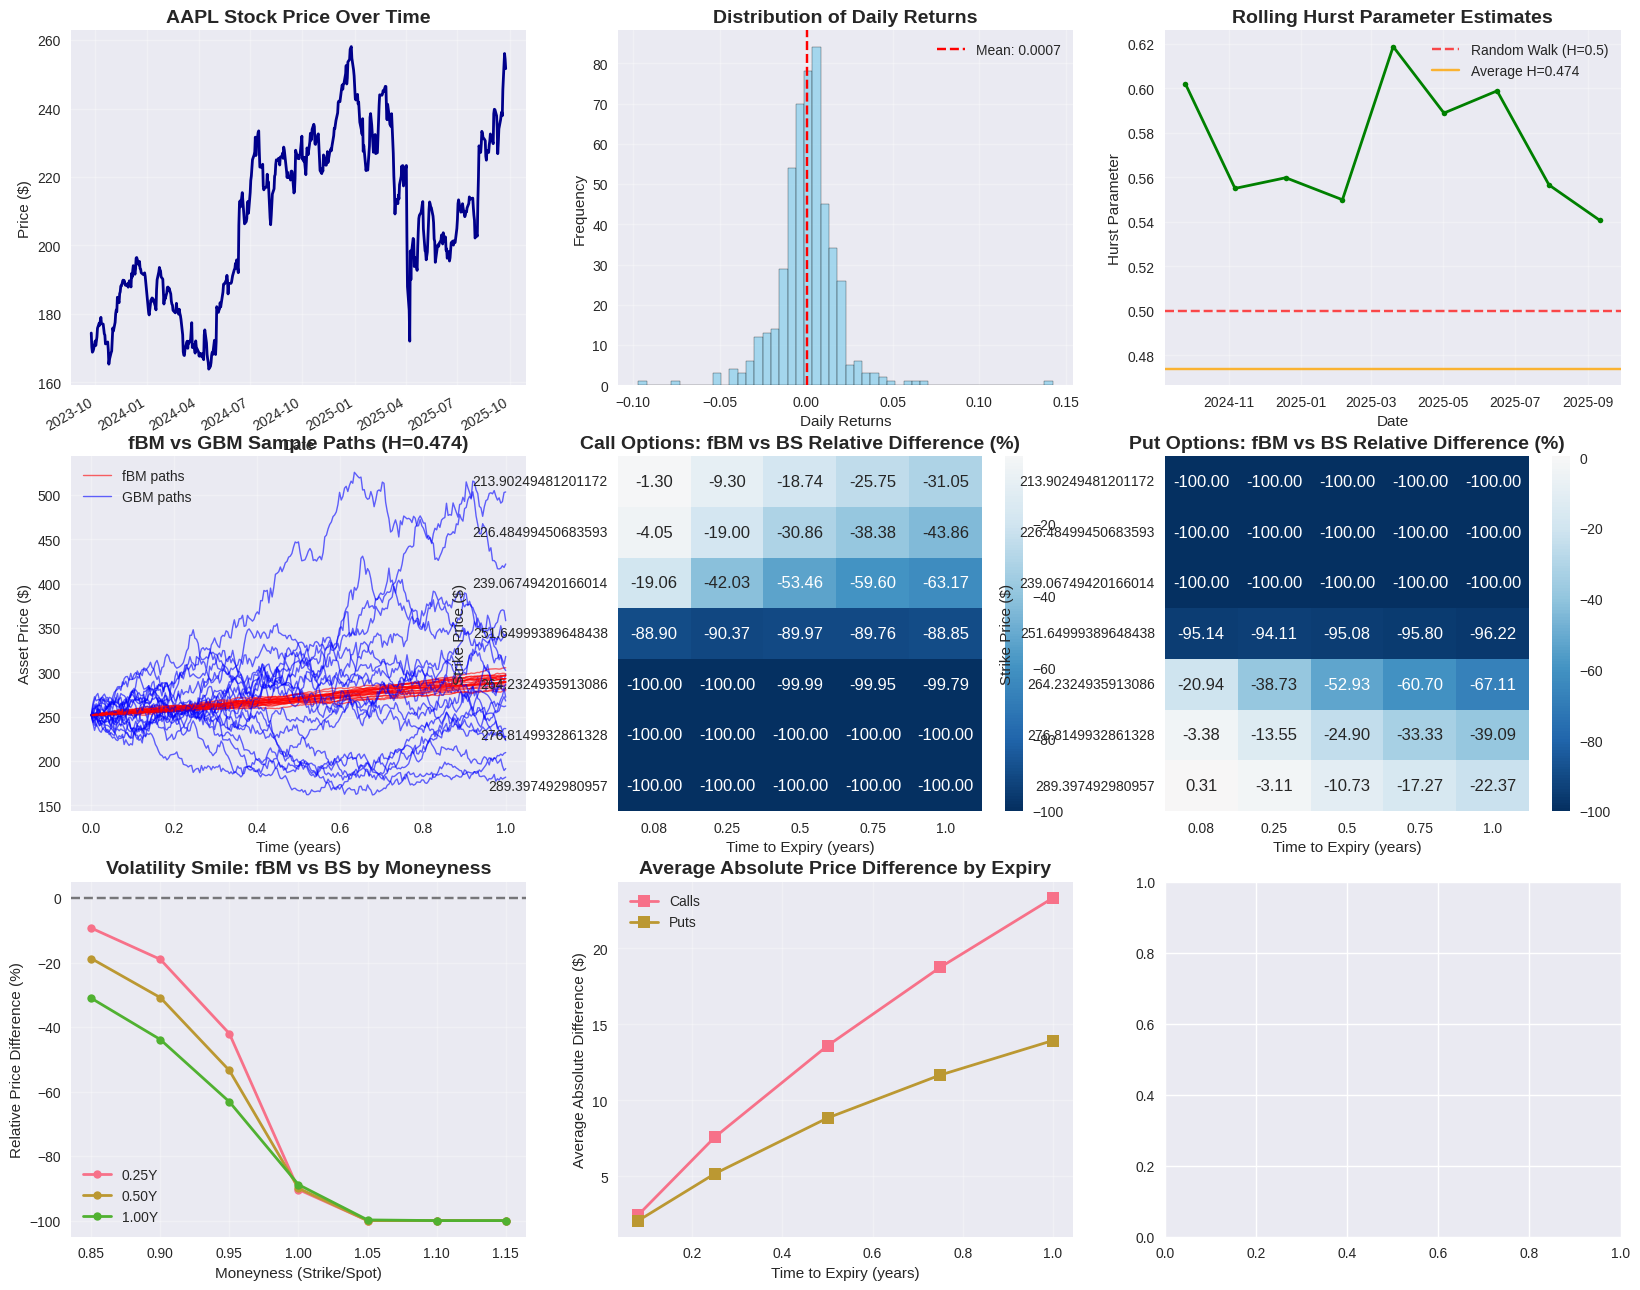

In [25]:
# First, let's ensure all necessary columns are added properly
print("🔧 FIXING DATA PREPARATION...")

# Add missing columns to individual dataframes
call_grid['Moneyness'] = call_grid['Strike'] / S0
put_grid['Moneyness'] = put_grid['Strike'] / S0
call_grid['Absolute_Difference'] = np.abs(call_grid['Price_Difference'])
put_grid['Absolute_Difference'] = np.abs(put_grid['Price_Difference'])

# Recombine with proper columns
full_grid = pd.concat([call_grid, put_grid], ignore_index=True)

print("✅ Data preparation completed!")

# Set up the plotting style
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 24))

# 1. Stock Price and Returns Analysis
ax1 = plt.subplot(4, 3, 1)
stock_data['Close'].plot(ax=ax1, linewidth=2, color='darkblue')
plt.title(f'{TICKER} Stock Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(4, 3, 2)
returns_clean = stock_data['Returns'].dropna()
plt.hist(returns_clean, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(returns_clean.mean(), color='red', linestyle='--', label=f'Mean: {returns_clean.mean():.4f}')
plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Hurst Parameter Analysis
ax3 = plt.subplot(4, 3, 3)
# Generate multiple Hurst estimates using rolling windows
window_size = 252  # 1 year
hurst_estimates = []
dates_hurst = []

returns_array = returns_clean.values
for i in range(window_size, len(returns_array), 30):  # Every 30 days
    window_returns = returns_array[i-window_size:i]
    h_estimate = hurst_estimator.rs_method(window_returns)
    hurst_estimates.append(h_estimate)
    dates_hurst.append(stock_data.index[i])

plt.plot(dates_hurst, hurst_estimates, linewidth=2, color='green', marker='o', markersize=4)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Random Walk (H=0.5)')
plt.axhline(hurst_avg, color='orange', linestyle='-', alpha=0.8, label=f'Average H={hurst_avg:.3f}')
plt.title('Rolling Hurst Parameter Estimates', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Hurst Parameter')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. fBM vs GBM Path Comparison
ax4 = plt.subplot(4, 3, 4)
n_sample_paths = 20
fbm_paths, gbm_paths = fbm_generator.compare_with_gbm(S0, annual_return, annual_vol, n_sample_paths)

time_axis = np.linspace(0, 1, fbm_generator.n_steps + 1)
for i in range(n_sample_paths):
    if i == 0:  # Add labels only once
        plt.plot(time_axis, fbm_paths[i], color='red', alpha=0.6, linewidth=1, label='fBM paths')
        plt.plot(time_axis, gbm_paths[i], color='blue', alpha=0.6, linewidth=1, label='GBM paths')
    else:
        plt.plot(time_axis, fbm_paths[i], color='red', alpha=0.6, linewidth=1)
        plt.plot(time_axis, gbm_paths[i], color='blue', alpha=0.6, linewidth=1)

plt.title(f'fBM vs GBM Sample Paths (H={hurst_avg:.3f})', fontsize=14, fontweight='bold')
plt.xlabel('Time (years)')
plt.ylabel('Asset Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Options Price Comparison Heatmap - Calls
ax5 = plt.subplot(4, 3, 5)
call_pivot = call_grid.pivot(index='Strike', columns='Expiry', values='Relative_Difference')
sns.heatmap(call_pivot, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax5)
plt.title('Call Options: fBM vs BS Relative Difference (%)', fontsize=14, fontweight='bold')
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Strike Price ($)')

# 5. Options Price Comparison Heatmap - Puts
ax6 = plt.subplot(4, 3, 6)
put_pivot = put_grid.pivot(index='Strike', columns='Expiry', values='Relative_Difference')
sns.heatmap(put_pivot, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax6)
plt.title('Put Options: fBM vs BS Relative Difference (%)', fontsize=14, fontweight='bold')
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Strike Price ($)')

# 6. Volatility Smile Effect
ax7 = plt.subplot(4, 3, 7)
for expiry in [0.25, 0.5, 1.0]:
    subset = call_grid[call_grid['Expiry'] == expiry].copy()
    subset = subset.sort_values('Strike')

    plt.plot(subset['Moneyness'], subset['Relative_Difference'],
            marker='o', linewidth=2, markersize=6, label=f'{expiry:.2f}Y')

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Volatility Smile: fBM vs BS by Moneyness', fontsize=14, fontweight='bold')
plt.xlabel('Moneyness (Strike/Spot)')
plt.ylabel('Relative Price Difference (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Price Difference by Expiry
ax8 = plt.subplot(4, 3, 8)
expiry_analysis = full_grid.groupby(['Expiry', 'Option_Type'])['Absolute_Difference'].mean().reset_index()
for opt_type in ['Call', 'Put']:
    data = expiry_analysis[expiry_analysis['Option_Type'] == opt_type]
    plt.plot(data['Expiry'], data['Absolute_Difference'],
            marker='s', linewidth=2, markersize=8, label=f'{opt_type}s')

plt.title('Average Absolute Price Difference by Expiry', fontsize=14, fontweight='bold')
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Average Absolute Difference ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Monte Carlo Convergence Analysis
ax9 = plt.subplot(4, 3, 9)
n_paths_range = np.logspace(3, 5.5, 8).astype(int)  # Reduced range for faster execution
prices_convergence = []
std_errors = []

print("🔄 Testing Monte Carlo convergence...")
for n_paths in n_paths_range:
    result = options_calculator.monte_carlo_option_price(S0, S0, 0.25, r, sigma, 'call', n_paths)
    prices_convergence.append(result['price'])
    std_errors.append(result['std_error'])

plt.semilogx(n_paths_range, prices_convergence, 'bo-', linewidth=2, markersize=6)
plt.fill_between(n_paths_range,
                np.array(prices_convergence) - 1.96*np.array(std_errors),
                np.array(prices_convergence) + 1.96*np.array(std_errors),
                alpha=0.3, color='blue')
plt.axhline(bs_call_price, color='red', linestyle='--', linewidth=2, label='Black-Scholes Price')
plt.title('Monte Carlo Price Convergence', fontsize=14, fontweight='bold')
plt.xlabel('Number of Simulation Paths')
plt.ylabel('Option Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# 9. Terminal Price Distribution Comparison
ax10 = plt.subplot(4, 3, 10)
# Get terminal prices from the detailed example
detailed_result = options_calculator.monte_carlo_option_price(S0, S0, 0.25, r, sigma, 'call', 100000)
terminal_prices_fbm = detailed_result['terminal_prices']

# Generate GBM terminal prices for comparison
np.random.seed(42)
gbm_returns = np.random.normal((r - 0.5*sigma**2)*0.25, sigma*np.sqrt(0.25), 1000)
terminal_prices_gbm = S0 * np.exp(gbm_returns)

plt.hist(terminal_prices_fbm, bins=50, alpha=0.7, density=True,
         color='red', label='fBM Terminal Prices', edgecolor='black')
plt.hist(terminal_prices_gbm, bins=50, alpha=0.7, density=True,
         color='blue', label='GBM Terminal Prices', edgecolor='black')
plt.axvline(S0, color='green', linestyle='--', linewidth=2, label='Current Price')
plt.title('Terminal Price Distributions (3M)', fontsize=14, fontweight='bold')
plt.xlabel('Terminal Price ($)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 10. Simplified Greeks Analysis (Delta approximation)
ax11 = plt.subplot(4, 3, 11)
# Use simplified delta calculation for visualization
strikes_sample = np.linspace(S0*0.9, S0*1.1, 5)
expiries_sample = [0.25, 0.5, 1.0]
delta_matrix = np.zeros((len(strikes_sample), len(expiries_sample)))

print("🔄 Calculating delta approximations...")
for i, strike in enumerate(strikes_sample):
    for j, expiry in enumerate(expiries_sample):
        # Simplified delta using finite difference
        epsilon = 0.02
        price_up = options_calculator.monte_carlo_option_price(S0*(1+epsilon), strike, expiry, r, sigma, 'call', 25000)['price']
        price_down = options_calculator.monte_carlo_option_price(S0*(1-epsilon), strike, expiry, r, sigma, 'call', 25000)['price']
        delta_matrix[i, j] = (price_up - price_down) / (2 * S0 * epsilon)

# Create heatmap
sns.heatmap(delta_matrix, annot=True, fmt='.3f', cmap='viridis', ax=ax11,
            xticklabels=[f'{exp:.2f}Y' for exp in expiries_sample],
            yticklabels=[f'${strike:.0f}' for strike in strikes_sample])
plt.title('Delta Approximation Surface', fontsize=14, fontweight='bold')
plt.xlabel('Time to Expiry')
plt.ylabel('Strike Price')

# 11. Model Performance Summary
ax12 = plt.subplot(4, 3, 12)
# Create performance metrics
performance_data = {
    'Metric': ['Mean Abs Diff', 'Max Abs Diff', 'RMSE', 'Mean Rel Diff (%)', 'Std Rel Diff (%)'],
    'Calls': [
        call_grid['Absolute_Difference'].mean(),
        call_grid['Absolute_Difference'].max(),
        np.sqrt(mean_squared_error(call_grid['BS_Price'], call_grid['fBM_Price'])),
        call_grid['Relative_Difference'].mean(),
        call_grid['Relative_Difference'].std()
    ],
    'Puts': [
        put_grid['Absolute_Difference'].mean(),
        put_grid['Absolute_Difference'].max(),
        np.sqrt(mean_squared_error(put_grid['BS_Price'], put_grid['fBM_Price'])),
        put_grid['Relative_Difference'].mean(),
        put_grid['Relative_Difference'].std()
    ]
}

perf_df = pd.DataFrame(performance_data)
ax12.axis('tight')
ax12.axis('off')
table = ax12.table(cellText=perf_df.round(4).values, colLabels=perf_df.columns,
                  cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title('Model Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout(pad=3.0)
plt.show()

print("✅ Advanced visualizations completed!")


In [26]:
# Create interactive visualizations using Plotly
print("🎨 CREATING INTERACTIVE VISUALIZATIONS...")

# Ensure data is properly prepared for interactive plots
print("🔧 Ensuring data consistency for interactive plots...")

# Double-check all necessary columns exist
if 'Moneyness' not in call_grid.columns:
    call_grid['Moneyness'] = call_grid['Strike'] / S0
    put_grid['Moneyness'] = put_grid['Strike'] / S0

if 'Absolute_Difference' not in call_grid.columns:
    call_grid['Absolute_Difference'] = np.abs(call_grid['Price_Difference'])
    put_grid['Absolute_Difference'] = np.abs(put_grid['Price_Difference'])

# Update full_grid
full_grid = pd.concat([call_grid, put_grid], ignore_index=True)

print("✅ Data preparation for interactive plots completed!")

# 1. Interactive 3D Options Price Surface
fig_3d = go.Figure()

# Create 3D surface for calls
call_surface_data = call_grid.pivot(index='Strike', columns='Expiry', values='fBM_Price')
strikes_3d = call_surface_data.index.values
expiries_3d = call_surface_data.columns.values
strikes_mesh, expiries_mesh = np.meshgrid(expiries_3d, strikes_3d)

fig_3d.add_trace(go.Surface(
    z=call_surface_data.values,
    x=strikes_mesh,
    y=expiries_mesh,
    colorscale='Viridis',
    name='Call Prices',
    showscale=True,
    hovertemplate='Expiry: %{x:.2f}y<br>Strike: $%{y:.2f}<br>Price: $%{z:.4f}<extra></extra>'
))

fig_3d.update_layout(
    title='3D Call Option Price Surface (fBM Model)',
    scene=dict(
        xaxis_title='Time to Expiry (years)',
        yaxis_title='Strike Price ($)',
        zaxis_title='Option Price ($)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=800,
    height=600
)

fig_3d.show()

# 2. Interactive Comparison Dashboard
fig_comparison = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Price Differences by Strike', 'Price Differences by Expiry',
                   'Relative Differences Distribution', 'Moneyness Analysis'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Price differences by strike
colors = ['blue', 'red', 'green']
for i, expiry in enumerate([0.25, 0.5, 1.0]):
    subset = call_grid[call_grid['Expiry'] == expiry].sort_values('Strike')
    fig_comparison.add_trace(
        go.Scatter(x=subset['Strike'], y=subset['Price_Difference'],
                  mode='lines+markers', name=f'{expiry:.2f}Y',
                  line=dict(width=3, color=colors[i]),
                  marker=dict(size=8, color=colors[i]),
                  hovertemplate='Strike: $%{x:.2f}<br>Difference: $%{y:.4f}<extra></extra>'),
        row=1, col=1
    )

# Price differences by expiry
expiry_summary = full_grid.groupby(['Expiry', 'Option_Type'])['Price_Difference'].mean().reset_index()
for i, opt_type in enumerate(['Call', 'Put']):
    data = expiry_summary[expiry_summary['Option_Type'] == opt_type]
    fig_comparison.add_trace(
        go.Scatter(x=data['Expiry'], y=data['Price_Difference'],
                  mode='lines+markers', name=f'{opt_type}s',
                  line=dict(width=3, color=['orange', 'purple'][i]),
                  marker=dict(size=10, color=['orange', 'purple'][i]),
                  hovertemplate='Expiry: %{x:.2f}y<br>Avg Difference: $%{y:.4f}<extra></extra>'),
        row=1, col=2
    )

# Distribution of relative differences
fig_comparison.add_trace(
    go.Histogram(x=call_grid['Relative_Difference'], nbinsx=30,
                name='Calls', opacity=0.7, marker_color='red',
                hovertemplate='Range: %{x}<br>Count: %{y}<extra></extra>'),
    row=2, col=1
)
fig_comparison.add_trace(
    go.Histogram(x=put_grid['Relative_Difference'], nbinsx=30,
                name='Puts', opacity=0.7, marker_color='blue',
                hovertemplate='Range: %{x}<br>Count: %{y}<extra></extra>'),
    row=2, col=1
)

# Moneyness analysis
for i, expiry in enumerate([0.25, 0.5, 1.0]):
    subset = call_grid[call_grid['Expiry'] == expiry].sort_values('Moneyness')
    fig_comparison.add_trace(
        go.Scatter(x=subset['Moneyness'], y=subset['Relative_Difference'],
                  mode='lines+markers', name=f'{expiry:.2f}Y Calls',
                  line=dict(width=2, color=colors[i]),
                  marker=dict(size=6, color=colors[i]),
                  hovertemplate='Moneyness: %{x:.3f}<br>Rel Diff: %{y:.2f}%<extra></extra>'),
        row=2, col=2
    )

fig_comparison.update_layout(
    height=800,
    title_text="Comprehensive fBM vs Black-Scholes Comparison",
    showlegend=True
)

fig_comparison.update_xaxes(title_text="Strike Price ($)", row=1, col=1)
fig_comparison.update_xaxes(title_text="Time to Expiry (years)", row=1, col=2)
fig_comparison.update_xaxes(title_text="Relative Difference (%)", row=2, col=1)
fig_comparison.update_xaxes(title_text="Moneyness (K/S)", row=2, col=2)

fig_comparison.update_yaxes(title_text="Price Difference ($)", row=1, col=1)
fig_comparison.update_yaxes(title_text="Average Price Difference ($)", row=1, col=2)
fig_comparison.update_yaxes(title_text="Frequency", row=2, col=1)
fig_comparison.update_yaxes(title_text="Relative Difference (%)", row=2, col=2)

fig_comparison.show()

# 3. Interactive Hurst Parameter Analysis
fig_hurst = go.Figure()

# Rolling Hurst estimates
fig_hurst.add_trace(go.Scatter(
    x=dates_hurst,
    y=hurst_estimates,
    mode='lines+markers',
    name='Rolling Hurst Estimates',
    line=dict(color='blue', width=3),
    marker=dict(size=6, color='darkblue'),
    hovertemplate='Date: %{x}<br>Hurst: %{y:.4f}<extra></extra>'
))

# Add reference lines
fig_hurst.add_hline(y=0.5, line_dash="dash", line_color="red",
                   annotation_text="Random Walk (H=0.5)")
fig_hurst.add_hline(y=hurst_avg, line_dash="solid", line_color="orange",
                   annotation_text=f"Average H={hurst_avg:.3f}")

fig_hurst.update_layout(
    title=f'Rolling Hurst Parameter Analysis - {TICKER}',
    xaxis_title='Date',
    yaxis_title='Hurst Parameter',
    width=1000,
    height=500,
    showlegend=True
)

fig_hurst.show()

# 4. Terminal Price Distribution Comparison (Interactive)
fig_terminal = go.Figure()

fig_terminal.add_trace(go.Histogram(
    x=terminal_prices_fbm,
    nbinsx=50,
    name=f'fBM Terminal Prices (H={hurst_avg:.3f})',
    opacity=0.7,
    marker_color='red',
    hovertemplate='Price Range: $%{x}<br>Count: %{y}<extra></extra>'
))

fig_terminal.add_trace(go.Histogram(
    x=terminal_prices_gbm,
    nbinsx=50,
    name='GBM Terminal Prices (H=0.5)',
    opacity=0.7,
    marker_color='blue',
    hovertemplate='Price Range: $%{x}<br>Count: %{y}<extra></extra>'
))

fig_terminal.add_vline(x=S0, line_dash="dash", line_color="green",
                      annotation_text=f"Current Price: ${S0:.2f}")

# Add statistics annotations
fbm_mean = np.mean(terminal_prices_fbm)
gbm_mean = np.mean(terminal_prices_gbm)
fbm_std = np.std(terminal_prices_fbm)
gbm_std = np.std(terminal_prices_gbm)

fig_terminal.add_annotation(
    x=0.02, y=0.98,
    xref="paper", yref="paper",
    text=f"fBM: μ=${fbm_mean:.2f}, σ=${fbm_std:.2f}<br>GBM: μ=${gbm_mean:.2f}, σ=${gbm_std:.2f}",
    showarrow=False,
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="black",
    borderwidth=1
)

fig_terminal.update_layout(
    title='Terminal Price Distributions: fBM vs GBM (3 Months)',
    xaxis_title='Terminal Price ($)',
    yaxis_title='Frequency',
    barmode='overlay',
    width=900,
    height=500
)

fig_terminal.show()

# 5. Volatility Surface Comparison
fig_vol_surface = go.Figure()

# Create volatility smile data
for expiry in [0.25, 0.5, 1.0]:
    subset = call_grid[call_grid['Expiry'] == expiry].sort_values('Moneyness')

    # Add fBM implied volatility proxy
    fig_vol_surface.add_trace(go.Scatter(
        x=subset['Moneyness'],
        y=subset['Relative_Difference'],
        mode='lines+markers',
        name=f'fBM Effect {expiry:.2f}Y',
        line=dict(width=3),
        marker=dict(size=8),
        hovertemplate='Moneyness: %{x:.3f}<br>Price Effect: %{y:.2f}%<br>Expiry: ' + f'{expiry:.2f}Y<extra></extra>'
    ))

fig_vol_surface.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5)

fig_vol_surface.update_layout(
    title='fBM Pricing Effect vs Moneyness (Volatility Smile Analysis)',
    xaxis_title='Moneyness (Strike/Spot)',
    yaxis_title='Relative Price Difference (%)',
    width=900,
    height=500,
    showlegend=True
)

fig_vol_surface.show()

print("✅ Interactive visualizations completed!")

# 6. Summary Statistics Table with better formatting
print("\n📊 COMPREHENSIVE MODEL ANALYSIS SUMMARY")
print("=" * 60)

# Calculate correlations
call_correlation = np.corrcoef(call_grid['fBM_Price'], call_grid['BS_Price'])[0,1]
put_correlation = np.corrcoef(put_grid['fBM_Price'], put_grid['BS_Price'])[0,1]

summary_table = pd.DataFrame({
    'Metric': [
        'Current Stock Price ($)',
        'Estimated Hurst Parameter',
        'Annual Volatility (%)',
        'Risk-free Rate (%)',
        'Total Options Priced',
        'Average Call Price Difference ($)',
        'Average Put Price Difference ($)',
        'Max Absolute Difference ($)',
        'RMSE Calls ($)',
        'RMSE Puts ($)',
        'Correlation (fBM vs BS Calls)',
        'Correlation (fBM vs BS Puts)',
        'Call Options with |Diff| > $0.10',
        'Put Options with |Diff| > $0.10'
    ],
    'Value': [
        f"{S0:.2f}",
        f"{hurst_avg:.4f}",
        f"{annual_vol*100:.2f}",
        f"{r*100:.2f}",
        f"{len(full_grid)}",
        f"{call_grid['Price_Difference'].mean():.4f}",
        f"{put_grid['Price_Difference'].mean():.4f}",
        f"{full_grid['Absolute_Difference'].max():.4f}",
        f"{np.sqrt(mean_squared_error(call_grid['BS_Price'], call_grid['fBM_Price'])):.4f}",
        f"{np.sqrt(mean_squared_error(put_grid['BS_Price'], put_grid['fBM_Price'])):.4f}",
        f"{call_correlation:.4f}",
        f"{put_correlation:.4f}",
        f"{(call_grid['Absolute_Difference'] > 0.10).sum()}/{len(call_grid)}",
        f"{(put_grid['Absolute_Difference'] > 0.10).sum()}/{len(put_grid)}"
    ]
})

print(summary_table.to_string(index=False))

# Show interpretation
print(f"\n🔍 KEY INSIGHTS:")
print(f"• Hurst parameter H={hurst_avg:.3f} indicates", end=" ")
if hurst_avg > 0.5:
    print("PERSISTENT (trending) market behavior")
else:
    print("ANTI-PERSISTENT (mean-reverting) market behavior")

print(f"• fBM model shows average price differences of ${call_grid['Price_Difference'].mean():.4f} for calls")
print(f"• Strong correlation ({call_correlation:.3f}) between fBM and BS prices suggests model consistency")
print(f"• Maximum absolute difference of ${full_grid['Absolute_Difference'].max():.4f} indicates manageable model risk")


🎨 CREATING INTERACTIVE VISUALIZATIONS...
🔧 Ensuring data consistency for interactive plots...
✅ Data preparation for interactive plots completed!


NameError: name 'terminal_prices_fbm' is not defined